In [20]:
from __future__ import print_function
import pandas as pd
import numpy as np
from glob import glob
from sklearn.preprocessing import MinMaxScaler


### 1. data load

In [21]:
train_sample = pd.read_csv('./dataset/CNC 비식별화 원본데이터_1209/train.csv',header=0,encoding='utf-8')
all_files = glob('./dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2/*.csv')
li_df = [pd.read_csv(filename,index_col=None,header=0) for filename in all_files] # for 문을 comprhension으로 빠르게 해결!

#### 1-2 데이터 개수 확인

In [22]:
nb_pass=0
nb_pass_half = 0
nb_defective = 0

train_sample_np = np.array(train_sample.copy())
for i in range(len(train_sample)):
    if train_sample_np[i,5]=='no':
        nb_defective+=1
    if train_sample_np[i,5]=='yes' and train_sample_np[i,6]=='yes':
        nb_pass+=1
    if train_sample_np[i,5]=='yes' and train_sample_np[i,6]=='no':
        nb_pass_half+=1

print('양품 샘플 개수: ',nb_pass)
print('공정 마쳤으나 육안검사 통과 못한 샘플 개수 :',nb_pass_half)
print('공정 중지된 샘플 개수: ',nb_defective)
print('전체 샘플 개수 : ',nb_pass+nb_defective+nb_pass_half)

양품 샘플 개수:  13
공정 마쳤으나 육안검사 통과 못한 샘플 개수 : 6
공정 중지된 샘플 개수:  6
전체 샘플 개수 :  25


### 2. 데이터 preprocessing

In [23]:
def tool_condition(input):
    for i in range(len(input)):
        input[i,4] = 0 if input[i,4]=='unworn' else 1
    return input

def item_inspection(input):
    for i in range(len(input)):
        if input[i,5] =='no':
            input[i,6] = 2
        elif input[i,5] =='yes' and input[i,6] =='no':
            input[i,6] = 1
        elif input[i,5] =='yes' and input[i,6] =='yes':
            input[i,6] = 0
    
    return input


def machining_process(input):
    for i in range(len(input)):
        for num,mode in enumerate([['Prep'],['Layer 1 Up'],['Layer 1 Down'],['Layer 2 Up'],['Layer 2 Down'],['Layer 3 Up'],['Layer 3 Down'], ['Repositioning'], ['end','End'],['Starting']]):
            if input[i,47] in mode:
                input[i,47]=num
                break
    return input
        

#### 2-2. 사용자 정의 함수의 사용을 통한 데이터 분류

In [24]:

train_sample_info = np.array(train_sample_np.copy())
train_sample_info = tool_condition(train_sample_info)
train_sample_info = item_inspection(train_sample_info)
print(train_sample_info)

[[1 'aluminum' 6 4.0 0 'yes' 0]
 [2 'aluminum' 20 4.0 0 'yes' 0]
 [3 'aluminum' 6 3.0 0 'yes' 0]
 [4 'aluminum' 6 2.5 0 'no' 2]
 [5 'aluminum' 20 3.0 0 'no' 2]
 [6 'aluminum' 6 4.0 1 'yes' 1]
 [7 'aluminum' 20 4.0 1 'no' 2]
 [8 'aluminum' 20 4.0 1 'yes' 1]
 [9 'aluminum' 15 4.0 1 'yes' 1]
 [10 'aluminum' 12 4.0 1 'yes' 1]
 [11 'aluminum' 3 4.0 0 'yes' 0]
 [12 'aluminum' 3 3.0 0 'yes' 0]
 [13 'aluminum' 3 4.0 1 'yes' 0]
 [14 'aluminum' 3 3.0 1 'yes' 0]
 [15 'aluminum' 6 3.0 1 'yes' 0]
 [16 'aluminum' 20 3.0 1 'no' 2]
 [17 'aluminum' 3 2.5 0 'yes' 0]
 [18 'aluminum' 3 2.5 1 'yes' 0]
 [19 'aluminum' 15 4.0 1 'yes' 1]
 [20 'aluminum' 12 4.0 0 'no' 2]
 [21 'aluminum' 3 4.0 0 'yes' 1]
 [22 'aluminum' 20 3.0 1 'yes' 0]
 [23 'aluminum' 3 4.0 1 'no' 2]
 [24 'aluminum' 3 3.0 0 'yes' 0]
 [25 'aluminum' 6 2.5 1 'yes' 0]]


In [25]:
train_sample_info = np.delete(train_sample_info,5,1)
train_sample_info = np.delete(train_sample_info,0,1)
train_sample_info = np.delete(train_sample_info,0,1)
print(train_sample_info)

[[6 4.0 0 0]
 [20 4.0 0 0]
 [6 3.0 0 0]
 [6 2.5 0 2]
 [20 3.0 0 2]
 [6 4.0 1 1]
 [20 4.0 1 2]
 [20 4.0 1 1]
 [15 4.0 1 1]
 [12 4.0 1 1]
 [3 4.0 0 0]
 [3 3.0 0 0]
 [3 4.0 1 0]
 [3 3.0 1 0]
 [6 3.0 1 0]
 [20 3.0 1 2]
 [3 2.5 0 0]
 [3 2.5 1 0]
 [15 4.0 1 1]
 [12 4.0 0 2]
 [3 4.0 0 1]
 [20 3.0 1 0]
 [3 4.0 1 2]
 [3 3.0 0 0]
 [6 2.5 1 0]]


In [26]:
li_pass = []
li_pass_half = []
li_fail = []
# 공정 상태 별 나누기
for k,filename in enumerate(all_files):
    df  = pd.read_csv(filename,index_col=None,header=0)
    if train_sample_info[k,3] ==0:
        li_pass.append(df)
    elif train_sample_info[k,3] ==1:
        li_pass_half.append(df)
    else:
        li_fail.append(df)
       

frame01 = pd.concat(li_pass,axis=0,ignore_index=True)
frame02 = pd.concat(li_pass_half,axis=0,ignore_index=True)
frame03 = pd.concat(li_fail,axis=0,ignore_index=True)
data_pass = np.array(frame01.copy())
data_pass_half = np.array(frame02.copy())
data_fail = np.array(frame03.copy())
print(f"공정완료 및 육안검사 합격한 전체 데이터 수 : {len(data_pass)}")
print(f"공정완료 및 육안검사 불합격한 전체 데이터 수 : {len(data_pass_half)}")
print(f"공정 미완료한 전체 데이터 수 : {len(data_fail)}")

공정완료 및 육안검사 합격한 전체 데이터 수 : 22645
공정완료 및 육안검사 불합격한 전체 데이터 수 : 6175
공정 미완료한 전체 데이터 수 : 3228


In [27]:
# machine process 값 변환
data_pass = machining_process(data_pass)
data_pass_half = machining_process(data_pass_half)
data_fail = machining_process(data_fail)

#### 2-3. 데이터 구성

In [28]:
data01 = data_pass[:len(data_pass_half)+len(data_fail),:]
data02 = data_pass_half# 사실 전부다!!!! 6175 = len(data_pass_half)
data03 = data_fail # 사실 전부다!!! 3228 = len(data_fail)

data = np.concatenate((data01,data02,data03),axis=0)
data_all = data_pass[len(data01):,:]

print(data.shape)
print(data_all.shape)

(18806, 48)
(13242, 48)


#### 2-4. 데이터 2차 전처리(normalization)

In [29]:
sc = MinMaxScaler()
X_train = np.array(sc.fit_transform(data))
X_test = np.array(sc.transform(data_all)) # fit_transform을 하는 것은 좋지 않다. 


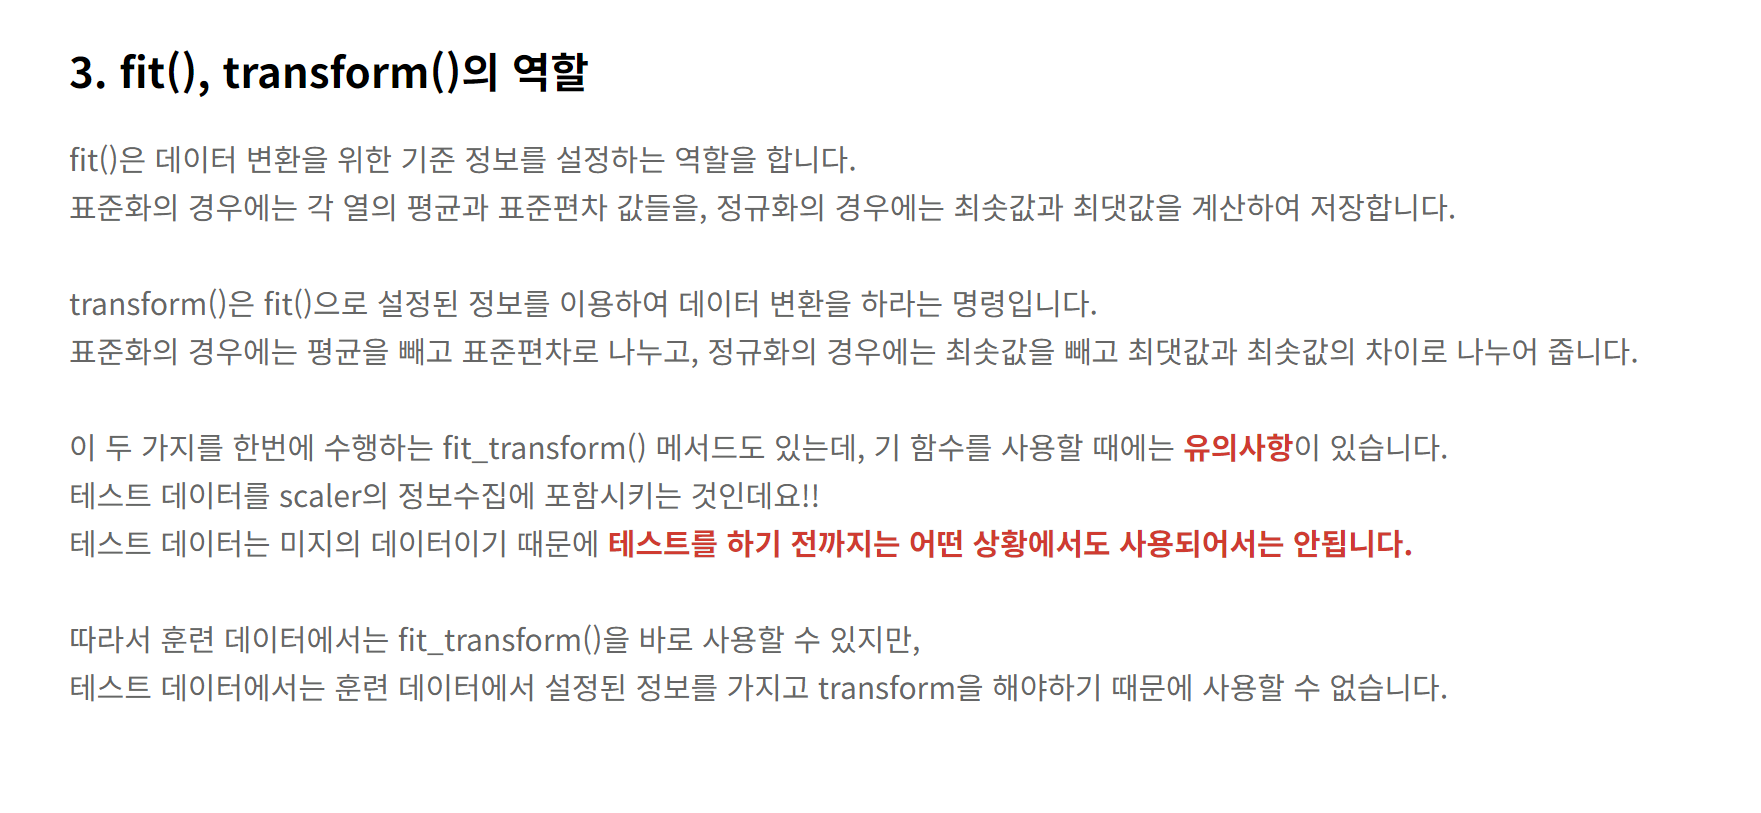

#### 3. 데이터 라벨링

#### 3-1. 라벨 데이터 제작

In [30]:
Y_train = np.zeros((len(X_train),1),dtype=np.int8)
Y_test = np.zeros((len(X_test),1),dtype=np.int8) # 빈데이터 
st = int(Y_train.shape[0]/2)
Y_train[st:,:] = 1
print(Y_train)

[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


### 5. 모델 구축

In [31]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.optimizers import AdamW # Adam + weight_decay 
from keras import initializers, regularizers,constraints
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, History
from keras.layers import Dense, Dropout
from keras import backend as K
from keras.utils import to_categorical

In [32]:
nb_classes = 2
batch_size = 1024
epochs = 100
lr = 1e-4

#### 5-2. AI 데이터셋 준비

In [33]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
Y_train = to_categorical(Y_train,nb_classes)
Y_test = to_categorical(Y_test,nb_classes)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)
pd.DataFrame(X_train).to_csv('./mydataset/X_train.csv',header=None,index=None)
pd.DataFrame(X_test).to_csv('./mydataset/X_test.csv',header=None,index=None)
pd.DataFrame(Y_train).to_csv('./mydataset/Y_train.csv',header=None,index=None)
pd.DataFrame(Y_test).to_csv('./mydataset/Y_test.csv',header=None,index=None)

(18806, 48) (18806, 2)
(13242, 48) (13242, 2)


#### 5-3. AI 모델 디자인

In [34]:
model = Sequential()
model.add(Dense(128,activation='relu',input_dim = 48))
model.add(Dropout(0.3))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(nb_classes,activation='sigmoid'))
model_checkpoint = ModelCheckpoint('./check/weight_CNC_binary.mat',monitor='val_acc',save_best_only=True) # val이 가장 좋은 것만 저장
opt = AdamW(lr)
model.summary()
model.compile(optimizer=opt,loss = 'binary_crossentropy',metrics=['accuracy'])
hist = History()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               6272      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               2

### 6. AI 모델 훈련

#### 6-1.  AI 모델 훈련

In [35]:
model.fit(X_train,Y_train,verbose=2,batch_size=batch_size,epochs=epochs,validation_split=0.2,shuffle=True,callbacks=[hist])
model.save_weights('./check/weight_CNC_binary_last.mat')

Epoch 1/100
15/15 - 2s - loss: 0.6738 - accuracy: 0.6153 - val_loss: 0.8443 - val_accuracy: 0.0000e+00 - 2s/epoch - 101ms/step
Epoch 2/100
15/15 - 0s - loss: 0.6573 - accuracy: 0.6250 - val_loss: 0.8971 - val_accuracy: 0.0000e+00 - 447ms/epoch - 30ms/step
Epoch 3/100
15/15 - 0s - loss: 0.6499 - accuracy: 0.6250 - val_loss: 0.8478 - val_accuracy: 0.0000e+00 - 489ms/epoch - 33ms/step
Epoch 4/100
15/15 - 0s - loss: 0.6432 - accuracy: 0.6250 - val_loss: 0.8450 - val_accuracy: 0.0000e+00 - 473ms/epoch - 32ms/step
Epoch 5/100
15/15 - 0s - loss: 0.6323 - accuracy: 0.6250 - val_loss: 0.8231 - val_accuracy: 0.0000e+00 - 467ms/epoch - 31ms/step
Epoch 6/100
15/15 - 0s - loss: 0.6175 - accuracy: 0.6260 - val_loss: 0.7796 - val_accuracy: 0.0912 - 488ms/epoch - 33ms/step
Epoch 7/100
15/15 - 1s - loss: 0.5972 - accuracy: 0.6357 - val_loss: 0.7720 - val_accuracy: 0.5008 - 501ms/epoch - 33ms/step
Epoch 8/100
15/15 - 1s - loss: 0.5677 - accuracy: 0.6804 - val_loss: 0.7976 - val_accuracy: 0.5638 - 570ms/

### 7. 결과 분석 및 해석

#### 7-1. AI 모델 훈련 결과 출력

In [18]:
print(model.evaluate(X_train,Y_train,batch_size=32))
print(model.evaluate(X_test,Y_test,batch_size=32)) # 

588/588 [==============================] - 1s 2ms/step - loss: 0.2186 - accuracy: 0.9496
[0.21862000226974487, 0.9496437311172485]
414/414 [==============================] - 1s 2ms/step - loss: 0.7359 - accuracy: 0.8938
[0.7358705997467041, 0.8938226699829102]


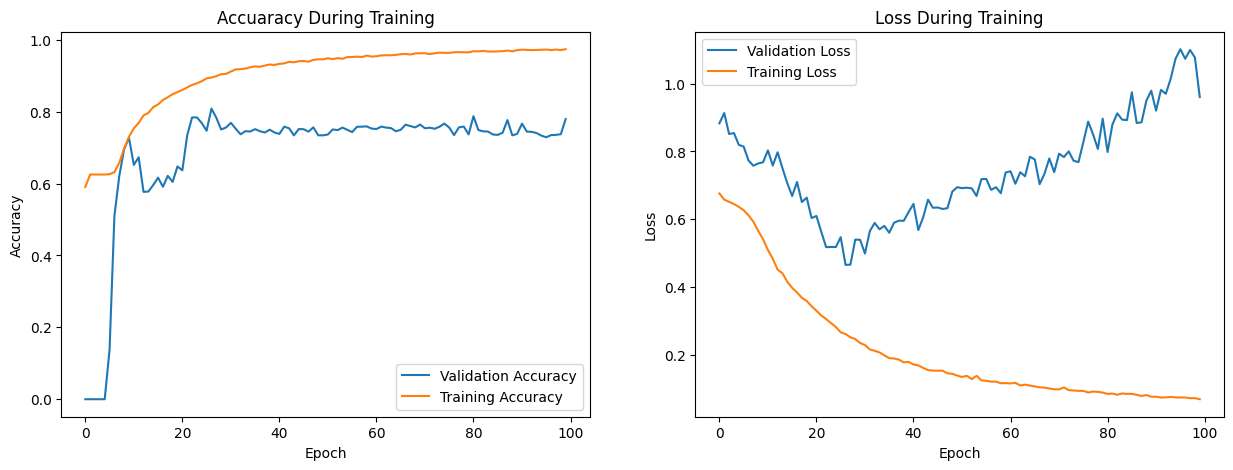

In [19]:
import matplotlib.pyplot as plt

f, g = plt.subplots(1,2,figsize = (15,5))
g[0].plot(hist.history['val_accuracy'])
g[0].plot(hist.history['accuracy'])
g[0].set_title('Accuaracy During Training')
g[0].set_xlabel('Epoch')
g[0].set_ylabel('Accuracy')
g[0].legend(['Validation Accuracy','Training Accuracy'])

g[1].plot(hist.history['val_loss'])
g[1].plot(hist.history['loss'])
g[1].set_title('Loss During Training')
g[1].set_xlabel('Epoch')
g[1].set_ylabel('Loss')
g[1].legend(['Validation Loss','Training Loss']);